# Basic depiction of a FEP workflow using BioSimSpace and Python

In [1]:
import BioSimSpace as BSS
import glob 
import csv
import numpy as np
import itertools


Sending anonymous Sire usage statistics to http://siremol.org.
For more information, see http://siremol.org/analytics
To disable, set the environment variable 'SIRE_DONT_PHONEHOME' to 1
To see the information sent, set the environment variable 
SIRE_VERBOSE_PHONEHOME equal to 1. To silence this message, set
the environment variable SIRE_SILENT_PHONEHOME to 1.



/Users/jscheen/miniconda3/envs/biosimspace-dev/lib/python3.7/site-packages/BioSimSpace/IO/_io.py:343: UserWarning: BioSimSpace.IO: Please install GROMACS (http://www.gromacs.org) for GROMACS topology file support.
  _warnings.warn("BioSimSpace.IO: Please install GROMACS (http://www.gromacs.org) "


### Variables

In [2]:
path_to_ligands = "inputs/ligands"
path_to_protein = "inputs/protein/tyk2_bss.pdb"

Set a protocol to run our simulations with. This file instructs BioSimSpace on the cluster. We will use a BioSimSpace gateway node for this to show the user which options can be chosen in an intuitive manner.

In [3]:
node = BSS.Gateway.Node("A node to create input files for molecular dynamics simulation.")

node.addInput("Ligand FF", BSS.Gateway.String(help="Force field to parameterise ligands with.",
                                             allowed=["GAFF1", "GAFF2", "OpenForceField"],
                                             default="GAFF2"))

node.addInput("Protein FF", BSS.Gateway.String(help="Force field to parameterise the protein with.",
                                             allowed=["FF03", "FF14SB", "FF99", "FF99SB", "FF99SBILDN"],
                                             default="FF14SB"))
node.addInput("Water Model", BSS.Gateway.String(help="Water model to use.",
                                             allowed=["SPC", "SPCE", "TIP3P", "TIP4P", "TIP5P"],
                                             default="TIP3P"))
node.addInput("Box Edges", BSS.Gateway.String(help="Size of water box around molecular system.",
                                             allowed=["20*angstrom", "25*angstrom", "30*angstrom", "35*angstrom", "45*angstrom", "5*nm", "7*nm", "10*nm"],
                                             default="20*angstrom"))
node.addInput("Box Shape", BSS.Gateway.String(help="Geometric shape of water box.",
                                             allowed=["orthorhombic", "triclinic"],
                                             default="orthorhombic"))

node.addInput("Run Time", BSS.Gateway.String(help="The sampling time per lambda window.",
                                             allowed=["10*ps", "100*ps", "1*ns", "2*ns", "3*ns", "4*ns", "5*ns", "8*ns", "10*ns", "12*ns", "15*ns"],
                                             default="4*ns"))

node.addInput("FEP Engine", BSS.Gateway.String(help="Engine to run FEP with.",
                                             allowed=BSS.FreeEnergy.engines(),
                                             default="Somd"))

node.addInput("LambdaWindows", BSS.Gateway.String(help="The number of lambda windows for regular transformations.",
                                             allowed=["3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20"],
                                             default="7"))
node.addInput("DiffLambdaWindows", BSS.Gateway.String(help="The number of lambda windows for difficult transformations.",
                                             allowed=["4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20"],
                                             default="12"))
node.addInput("LOMAP Threshold", BSS.Gateway.String(help="The LOMAP score threshold to define difficult transformations.",
                                             allowed=["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9"],
                                             default="0.4"))
node.showControls()

Box(children=(Box(children=(Box(children=(Label(value='Ligand FF: Force field to parameterise ligands with.'),…

## 1. With our collection of ligands, figure out which perturbations we should run.

The reliability of FEP calculations is typically higher for transformations with fewer heavy atom changes and some other rules (e.g. no ring formations). LOMAP is a package that contains heuristics for this and is able to come up with a network for us; BioSimSpace contains a function generateNetwork() that uses LOMAP to come up with the perturbation network that visualises the desired perturbations. Additionally, a LOMAP score is calculated which quantifies the likeliness that the FEP prediction will be reliable (0 means unlikely, 1 means highly likely).

This function requires a list of BioSimSpace molecule objects.

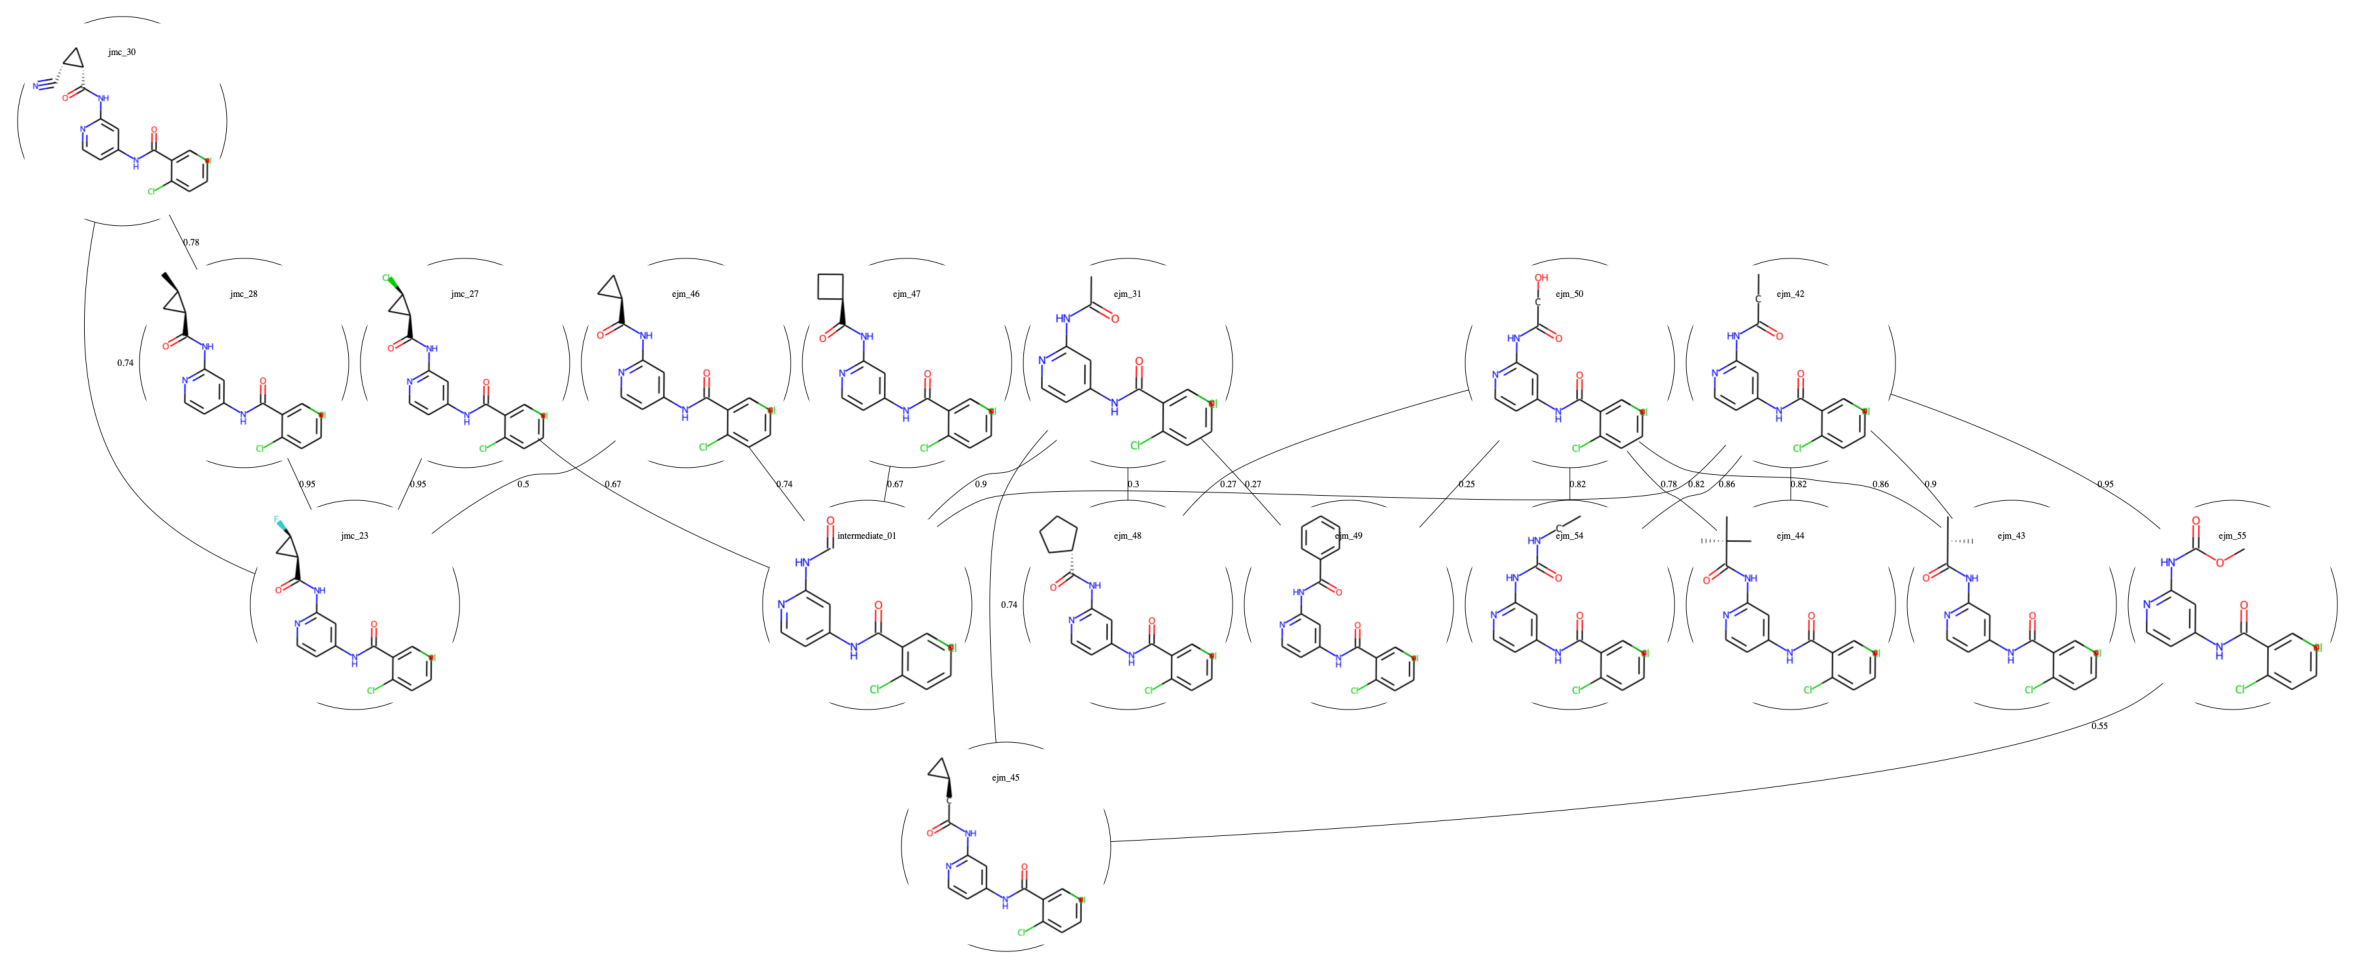

In [4]:
ligand_files = glob.glob("{}/*.mol2".format(path_to_ligands))

ligands = []
ligand_names = []

for filepath in ligand_files:
    # append the molecule object to a list.
    ligands.append(BSS.IO.readMolecules(filepath)[0])
    
    # append the molecule name to another list so that we can use the name of each molecule in our workflow.
    ligand_names.append(filepath.split("/")[-1].replace(".mol2",""))

tranformations, lomap_scores = BSS.Align.generateNetwork(ligands, plot_network=True, names=ligand_names)

BioSimSpace uses NetworkX which works with node indices for node names. Let's adjust our list of edges to have ligand names instead of ligand indices. We also generate a dictionary that contains all of the network information we need downstream.

In [9]:
pert_network_dict = {}
transformations_named = [(ligand_names[transf[0]], ligand_names[transf[1]]) for transf in tranformations]
for transf, score in zip(transformations_named, lomap_scores):
    print(transf, score)
    pert_network_dict[transf] = score

('ejm_31', 'intermediate_01') 0.90484
('ejm_31', 'ejm_48') 0.30119
('ejm_31', 'ejm_45') 0.74082
('ejm_31', 'ejm_49') 0.27253
('ejm_50', 'ejm_54') 0.81873
('ejm_50', 'ejm_43') 0.86071
('ejm_50', 'ejm_48') 0.27253
('ejm_50', 'ejm_44') 0.7788
('ejm_50', 'ejm_49') 0.2466
('ejm_46', 'intermediate_01') 0.74082
('ejm_46', 'jmc_23') 0.49659
('ejm_47', 'intermediate_01') 0.67032
('jmc_30', 'jmc_28') 0.7788
('jmc_30', 'jmc_23') 0.74082
('jmc_27', 'intermediate_01') 0.67032
('jmc_27', 'jmc_23') 0.95123
('ejm_42', 'ejm_54') 0.86071
('ejm_42', 'intermediate_01') 0.81873
('ejm_42', 'ejm_55') 0.95123
('ejm_42', 'ejm_43') 0.90484
('ejm_42', 'ejm_44') 0.81873
('jmc_28', 'jmc_23') 0.95123
('ejm_55', 'ejm_45') 0.54881


Unfortunately, even cutting-edge perturbation network generators such as LOMAP require some manual tweaking. In some cases, a ligand will have poor LOMAP scores on its edges and is therefore likely to be unreliable. To increase its reliability we often want to create an additional edge to this ligand, which can be easily done by appending the edge to our list of edges. 

In this case, we have introduced a ligand 'intermediate_01' that contains no atoms on the R-group. This makes it easier for the FEP code to perturb to cyclical R-groups. Using this type of network manipulation allows the user to include some cycles into the network, which is good for statistical performance of FEP predictions.

In [10]:
pert_network_dict[('intermediate_01', 'ejm_23')] = 0.1
pert_network_dict[('intermediate_01', 'ejm_48')] = 0.1
pert_network_dict[('intermediate_01', 'ejm_49')] = 0.1

pert_network_dict

{('ejm_31', 'intermediate_01'): 0.90484,
 ('ejm_31', 'ejm_48'): 0.30119,
 ('ejm_31', 'ejm_45'): 0.74082,
 ('ejm_31', 'ejm_49'): 0.27253,
 ('ejm_50', 'ejm_54'): 0.81873,
 ('ejm_50', 'ejm_43'): 0.86071,
 ('ejm_50', 'ejm_48'): 0.27253,
 ('ejm_50', 'ejm_44'): 0.7788,
 ('ejm_50', 'ejm_49'): 0.2466,
 ('ejm_46', 'intermediate_01'): 0.74082,
 ('ejm_46', 'jmc_23'): 0.49659,
 ('ejm_47', 'intermediate_01'): 0.67032,
 ('jmc_30', 'jmc_28'): 0.7788,
 ('jmc_30', 'jmc_23'): 0.74082,
 ('jmc_27', 'intermediate_01'): 0.67032,
 ('jmc_27', 'jmc_23'): 0.95123,
 ('ejm_42', 'ejm_54'): 0.86071,
 ('ejm_42', 'intermediate_01'): 0.81873,
 ('ejm_42', 'ejm_55'): 0.95123,
 ('ejm_42', 'ejm_43'): 0.90484,
 ('ejm_42', 'ejm_44'): 0.81873,
 ('jmc_28', 'jmc_23'): 0.95123,
 ('ejm_55', 'ejm_45'): 0.54881,
 ('intermediate_01', 'ejm_23'): 0.1,
 ('intermediate_01', 'ejm_48'): 0.1,
 ('intermediate_01', 'ejm_49'): 0.1}

Another way to manipulate the dictionary is to remove entries (i.e. remove edges from the network). When we look at the edges suggested by LOMAP that have low scores, we see that some are likely to be unreliable in FEP. Luckily, this is because cycle formation/removal in a single-topology-style FEP must be from/to a hydrogen, not a carbon atom. This is why we have introduced 'intermediate_01', so we can remove these edges.

In [11]:
for key in [('ejm_50', 'ejm_48'), ('ejm_31', 'ejm_49')]:
    del pert_network_dict[key]
pert_network_dict

{('ejm_31', 'intermediate_01'): 0.90484,
 ('ejm_31', 'ejm_48'): 0.30119,
 ('ejm_31', 'ejm_45'): 0.74082,
 ('ejm_50', 'ejm_54'): 0.81873,
 ('ejm_50', 'ejm_43'): 0.86071,
 ('ejm_50', 'ejm_44'): 0.7788,
 ('ejm_50', 'ejm_49'): 0.2466,
 ('ejm_46', 'intermediate_01'): 0.74082,
 ('ejm_46', 'jmc_23'): 0.49659,
 ('ejm_47', 'intermediate_01'): 0.67032,
 ('jmc_30', 'jmc_28'): 0.7788,
 ('jmc_30', 'jmc_23'): 0.74082,
 ('jmc_27', 'intermediate_01'): 0.67032,
 ('jmc_27', 'jmc_23'): 0.95123,
 ('ejm_42', 'ejm_54'): 0.86071,
 ('ejm_42', 'intermediate_01'): 0.81873,
 ('ejm_42', 'ejm_55'): 0.95123,
 ('ejm_42', 'ejm_43'): 0.90484,
 ('ejm_42', 'ejm_44'): 0.81873,
 ('jmc_28', 'jmc_23'): 0.95123,
 ('ejm_55', 'ejm_45'): 0.54881,
 ('intermediate_01', 'ejm_23'): 0.1,
 ('intermediate_01', 'ejm_48'): 0.1,
 ('intermediate_01', 'ejm_49'): 0.1}

## 2. Write files for execution model
These data files are used when running a FEP pipeline using BSS. Copy the folder ./execution_model/ to a server to parallelise your simulations.

In [12]:
# write ligands file.
with open("./execution_model/ligands.dat", "w") as ligands_file:
    writer = csv.writer(ligands_file)
    for lig in ligand_names:
        writer.writerow([lig])

In [13]:
# write perts file. Base the lambda schedule on the file generated in the previous cell.
np.set_printoptions(formatter={'float': '{: .4f}'.format})

# from protocol, derive the engine we want to use on the cluster.
engine = node.getInput('FEP Engine').upper()


with open("./execution_model/network.dat", "w") as network_file:

    writer = csv.writer(network_file, delimiter=" ")
    
    for pert, lomap_score in pert_network_dict.items():
        # based on the provided (at top of notebook) lambda allocations and LOMAP threshold, decide allocation.
        if lomap_score == None or lomap_score < float(node.getInput("LOMAP Threshold")):
            num_lambda = node.getInput("DiffLambdaWindows")
        else:
            num_lambda = node.getInput("LambdaWindows")
            
       
        # given the number of allocated lambda windows, generate an array for parsing downstream.
        lam_array_np = np.around(np.linspace(0, 1, int(num_lambda)), decimals=5)

        # make the array into a format readable by bash.
        lam_array = str(lam_array_np).replace("[ ", "").replace("]", "").replace("  ", ",").replace('\n', '')

        # write out both directions for this perturbation.
        writer.writerow([pert[0], pert[1], len(lam_array_np), lam_array, engine])
        writer.writerow([pert[1], pert[0], len(lam_array_np), lam_array, engine])         

In [14]:
# create protocol. 
protocol = [
    f"ligand forcefield = {node.getInput('Ligand FF')}",
    f"protein forcefield = {node.getInput('Protein FF')}",
    f"solvent = {node.getInput('Water Model')}",
    f"box edges = {node.getInput('Box Edges')}",
    f"box type = {node.getInput('Box Shape')}",
    f"protocol = default",
    f"sampling = {node.getInput('Run Time')}",
    f"engine = {node.getInput('FEP Engine').upper()}"
]

# write protocol to file.
with open("./execution_model/protocol.dat", "w") as protocol_file:
    writer = csv.writer(protocol_file)

    for prot_line in protocol:
        
        writer.writerow([prot_line])

Finally, parameterise our protein structure and save the system to the execution model folder.

In [15]:
prot = BSS.IO.readPDB(path_to_protein, pdb4amber=False)[0]
# depending on the picked forcefield nad your protein, tleap might fail. Check work_dir to see error logs.

prot_p = BSS.Parameters.parameterise(prot, node.getInput("Protein FF")).getMolecule()

MissingSoftwareError: 'BioSimSpace.Parameters.ff14SB' is not supported. Please install AmberTools (http://ambermd.org).

In [16]:
BSS.IO.saveMolecules("execution_model/inputs/protein/protein", prot_p, fileformat=["PRM7", "RST7"])

NameError: name 'prot_p' is not defined

Save the ligands to the execution model folder as well.

In [26]:
for lig, name in zip(ligands, ligand_names):
    BSS.IO.saveMolecules("execution_model/inputs/ligands/"+name, lig, "MOL2")

### After executing all cells you can move the folder ./execution_model/ to a cluster/server using for instance SCP. 
The simulations are run by executing the processFEP-slurm.sh or processFEP-lsf.sh script (depending on your cluster's setup). Note that there are several settings at the top of those shell scripts to make the FEP pipeline work with your cluster! 